### End-to-end pipeline to split a video

In [1]:
from src.bouldering.media.video.video import Video

In [2]:
# 1. Read the input video
VIDEO_PATH = "../data/video.mp4"

video = Video.read(VIDEO_PATH)
print(video.metadata)

{'video': {'fps': 25.0, 'n_frames': 10500, 'resolution': (1280, 720)}, 'audio': {'sample_rate': 44100, 'duration': 420.0025396825397}}


In [3]:
# Split the video
# macro splitter: OCR based
# micro splitter: Content based

from src.bouldering.models.ocr.splitter import SceneSplitterOCR
from src.bouldering.structure.scenes.ocr import OCRSplitter
from src.bouldering.structure.scenes.content import ContentSplitter
from src.bouldering.structure.pipeline import ScenePipeline

# OCR splitter
ocr_logic = SceneSplitterOCR(
    langs=["en"],
    crop_box=[0, 0.5, 0.5, 1],  # <-- relative coords
    fx=0.5,
    fy=0.5,
    stride=3,
    batch_size=16,
    smooth_window=5,
    majority_ratio=0.6,
    require_number=True,
)

ocr_splitter = OCRSplitter(ocr_logic)

# Content splitter
content_splitter = ContentSplitter(
    threshold=27.0,
    min_scene_len_sec=1.5,
    downscale=2,
)

# Wrapper pipeline
pipeline = ScenePipeline(
    macro_splitter=ocr_splitter,
    micro_splitter=content_splitter,
)

/home/souheil_laptop/anaconda3/envs/altaroad310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using CPU. Note: This module is much faster with a GPU.


In [4]:
# run pipeline
scenes = pipeline.run(video.cut(0.0, 40.0))

len(scenes)

OCR scene splitting:   0%|          | 0/1000 [00:00<?, ?frame/s]/home/souheil_laptop/anaconda3/envs/altaroad310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
OCR scene splitting: 100%|██████████| 1000/1000 [03:05<00:00,  5.38frame/s]
Downscale factor will be ignored because auto_downscale=True!


2

In [5]:
scenes

[Scene(start_time=20.4, end_time=31.84, label='boulder_1', metadata={'parent': Scene(start_time=20.4, end_time=40.0, label='boulder_1', metadata={'source': 'ocr'}), 'source': 'ocr+content'}),
 Scene(start_time=31.84, end_time=40.0, label='boulder_1', metadata={'parent': Scene(start_time=20.4, end_time=40.0, label='boulder_1', metadata={'source': 'ocr'}), 'source': 'ocr+content'})]

In [16]:
# let's take a scene
scene = scenes[1]
video_part = video.cut(scene.start_time, scene.end_time)

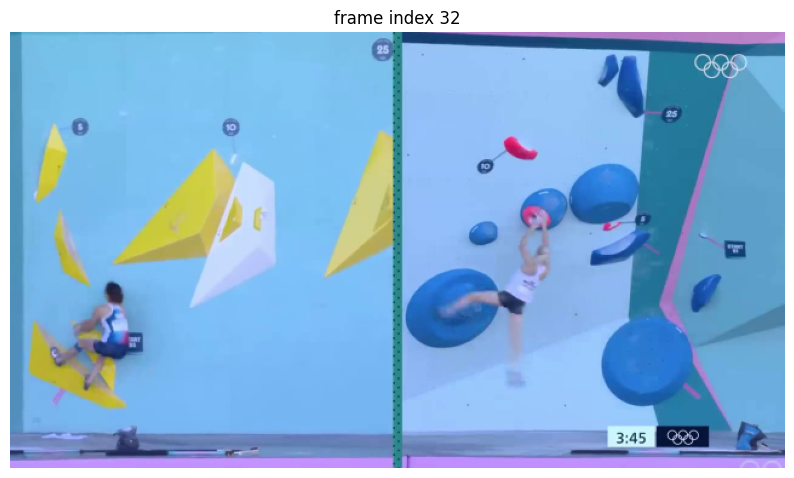

In [20]:
# let's print a frame from the scene
import random
from src.bouldering.visualization.detection import plot_frame
from src.bouldering.utils.image import resize


sequence_part = video_part.sequence
idx = random.randint(0, sequence_part.n_frames)
frame = sequence_part.frame(idx)

plot_frame(resize(frame, 0.5, 0.5), title=f"frame index {idx}")

In [21]:
# Let's make person detection and tracking on this scene
from src.bouldering.models.detection.tracking import YoloPersonTracker
from src.bouldering.models.detection.yolo import YoloPersonDetector

model = YoloPersonDetector()
tracker = YoloPersonTracker(model, fps = sequence_part.fps)
tracker.track_frames(sequence_part.frames())

defaultdict(list,
            {1: [{'frame': 0,
               'bbox': BBox(x1=100.58331298828125, y1=388.53448486328125, x2=196.2974853515625, y2=588.6451416015625),
               'confidence': 0.7018628120422363},
              {'frame': 1,
               'bbox': BBox(x1=99.62846374511719, y1=385.42413330078125, x2=196.59471130371094, y2=590.3005981445312),
               'confidence': 0.8062619566917419},
              {'frame': 2,
               'bbox': BBox(x1=97.42196655273438, y1=381.65313720703125, x2=197.1044921875, y2=589.1321411132812),
               'confidence': 0.7335671782493591},
              {'frame': 3,
               'bbox': BBox(x1=80.66688537597656, y1=378.490966796875, x2=196.39186096191406, y2=588.0999755859375),
               'confidence': 0.8205836415290833},
              {'frame': 4,
               'bbox': BBox(x1=74.40292358398438, y1=375.93310546875, x2=194.30947875976562, y2=586.9693603515625),
               'confidence': 0.8706628084182739},
        